In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pyarrow
import os
import re

### Plotting AUROC and AUPRC Curves with Data Exported from Slideflow

In [92]:
def generate_auroc_prc_curve(datasets, path_to_save_plot, colors, labels, title, curve_type='auroc', 
                            dataset_folder=True, file_type='parquet', uq_thresholds=None, youden=False, 
                            legend_loc='lower left', legend_size=8, outcome='pred_1'):
    '''
    Generate and save an AUROC or AUPRC curve from prediction data.
    Calculations are based on each DataFrame or data file provided 
    to the datasets argument. 

    Inputs:
    datasets (lst[DataFrame] or str): list of prediction DataFrames
    or string path to a folder containing data files. If using a string,
    dataset_folder must be True and file_type must be specified (default 'parquet')
    path_to_save_plot (str): path to location to save plot
    colors (lst[str]): list of strings indicating colors to use for lines on plot
    labels (lst[str]): list of strings to use as legend labels for each line
    title (str): Plot title
    curve_type (str): Indicates what kind of plot to calculate. Options are 'auroc'
    or 'auprc'. Default is 'auroc'. 
    dataset_folder (Optional, bool): indicates whether datasets is a string path to a 
    folder of dataset files (True) or a list of DataFrames (False). Default
    is True. 
    file_type (Optional, str): indicates the data file type to be loaded if a path to a
    folder with data files is used instead of a list of DataFrames. Default
    is 'parquet'
    uq_thresholds (Optional, lst[int]): List of uncertainty thresholds to use for uncertainty
    thresholding. List of values must be in the corresponding order of either 
    the DataFrames in the list datasets, or in the order that data files will
    be loaded from a datasets path. Default is None. 
    youden (Optional, bool): Indicates whether to show Youden's index in the figure legend next to AUROC.
    legend_loc (Optional, str): location to specify for legend. Uses matplotlib locations. Default is 'lower left'.
    legend_size (Optional, int): proportional font size for legend. Default is 8. 

    Outputs:
    Saves a .png image of an AUROC plot to the path specified by path_to_save_plot
    
    '''
    sns.set_style('darkgrid')
    if outcome=='pred_1':
        pos_label = 1
    if outcome=='pred_0':
        pos_label = 0
    if dataset_folder is True:
        predictions = os.listdir(datasets)
        path = datasets+'/'
        datasets = []
        for p in predictions:
            df = pd.read_parquet(path+p)
            datasets.append(df)
    renamed_datasets = []
    for df in datasets:
        cols = df.columns.values
        for c in cols:
            if 'pred0' in c:
                pred_0 = c
            if 'pred1' in c:
                pred_1 = c
            if 'true' in c:
                truth = c
        df = df.rename(columns={pred_0:'pred_0', pred_1:'pred_1', truth:'truth'}).copy()
        renamed_datasets.append(df)
    y_true = []
    y_pred = []
    for df in renamed_datasets:
        prediction = df[outcome].to_numpy()
        truth = df['truth'].to_numpy()
        y_pred.append(prediction)
        y_true.append(truth)
    if curve_type=='auroc':
        aurocs = []
        for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
            fpr, tpr, threshold = metrics.roc_curve(yt, yp)
            s_fpr = pd.Series(fpr)
            s_tpr = pd.Series(tpr)
            col_fpr = 'fpr_' + labels[i]
            col_tpr = 'tpr_' + labels[i]
            idx = np.argmax(tpr - fpr)
            youden = threshold[idx]
            roc_auc = metrics.auc(fpr, tpr)
            aurocs += [roc_auc]
            if youden is True:
                label = f'{labels[i]} (AUC: {roc_auc:.2f}, Youden: {youden:.2f})'
            else:
                label = f'{labels[i]} (AUC: {roc_auc:.2f})'
            plt.plot(fpr, tpr, colors[i % len(colors)], label=label, lw=0.8)
        plt.legend(loc='lower right', prop={'size':8})
        plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--', lw=0.5)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('TPR')
        plt.xlabel('FPR')
    if curve_type=='auprc':
        if youden is True:
            raise ValueError("Cannot calculate Youden's Index for an AUPRC. \
                Change plot type to 'auroc' or youden to False.")
        pres = []
        for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
            precision, recall, threshold = metrics.precision_recall_curve(yt, yp, pos_label=pos_label)
            s_precision = pd.Series(precision)
            s_recall = pd.Series(recall)
            col_precision = 'precision_' + labels[i]
            col_recall = 'recall_' + labels[i]
            roc_auprc = metrics.average_precision_score(yt, yp, pos_label=pos_label)
            pres += [roc_auprc]
            label_2 = f'{labels[i]} (AUPRC: {roc_auprc:.2f})'
            plt.plot(precision, recall, colors[i % len(colors)], label=label_2, lw=0.8)
        plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--', lw=0.5)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    plt.legend(loc=legend_loc, prop={'size':legend_size})
    plt.title(title)
    plt.savefig(path_to_save_plot, dpi=600, bbox_inches='tight')
    return


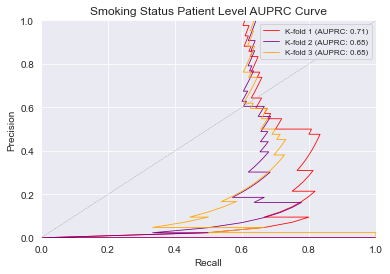

In [8]:
path_to_save_plot = '/Users/emmadyer/Desktop/pearson_lab/PROJECTS/oscc_smoking/smoking_and_vs_model_plots/auprc_patient_smoking_status.png'
colors = ['red', 'purple', 'orange', 'green', 'magenta']
labels = ['K-fold 1', 'K-fold 2', 'K-fold 3']
title = 'Smoking Status Patient Level AUPRC Curve'
datasets = '/Users/emmadyer/Desktop/pearson_lab/PROJECTS/oscc_smoking/smoking_predictions/patient_preds'

generate_auroc_prc_curve(datasets=datasets, path_to_save_plot=path_to_save_plot, curve_type='auprc', colors=colors,labels=labels, title=title, 
                            legend_loc='upper right')


In [83]:
auprc_test_df = pd.read_parquet('/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/predictions/patient_predictions_eval.parquet.gzip')

precision, recall, _ = metrics.precision_recall_curve(auprc_test_df.iloc[:, 3], auprc_test_df.iloc[:,2], pos_label=0)
prs = metrics.average_precision_score(auprc_test_df.iloc[:, 3], auprc_test_df.iloc[:,1], pos_label=0)
print(prs)

0.8761655890615168


0.7129192717507944
Tile Level (AUPRC: 0.71)
0.8761655890615168
Patient Level (AUPRC: 0.88)
0.8721907996830597
Slide Level (AUPRC: 0.87)


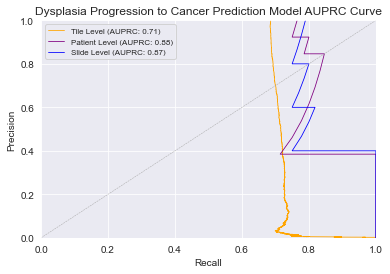

In [94]:
path_to_save_plot = '/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/figures/dysplasia_auprc.png'
colors = ['orange', 'purple', 'blue']
labels = ['Tile Level', 'Patient Level', 'Slide Level']
title = 'Dysplasia Progression to Cancer Prediction Model AUPRC Curve'
datasets = '/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/predictions'

generate_auroc_prc_curve(datasets=datasets, path_to_save_plot=path_to_save_plot, curve_type='auprc', colors=colors, labels=labels, title=title, legend_loc='upper left', outcome='pred_0')

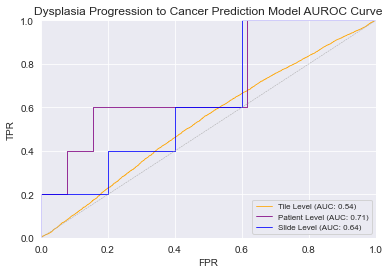

In [70]:
path_to_save_plot = '/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/figures/dysplasia_auroc.png'
colors = ['orange', 'purple', 'blue']
labels = ['Tile Level', 'Patient Level', 'Slide Level']
title = 'Dysplasia Progression to Cancer Prediction Model AUROC Curve'
datasets = '/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/predictions'

generate_auroc_prc_curve(datasets=datasets, path_to_save_plot=path_to_save_plot, curve_type='auroc', colors=colors, labels=labels, title=title, legend_loc='lower right')

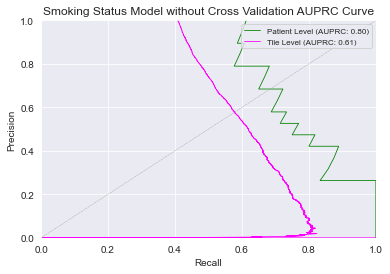

In [3]:
path_to_save_plot = '/Users/emmadyer/Desktop/pearson_lab/PROJECTS/oscc_smoking/smoking_and_vs_model_plots/no_cv_auprc.png'
colors = ['green', 'magenta', 'blue']
labels = ['Patient Level', 'Slide Level', 'Tile Level']
title = 'Smoking Status Model without Cross Validation AUPRC Curve'
datasets = '/Users/emmadyer/Desktop/pearson_lab/PROJECTS/oscc_smoking/no_cv_model_pred'

generate_auroc_prc_curve(datasets=datasets, path_to_save_plot=path_to_save_plot, curve_type='auprc', colors=colors, labels=labels, title=title, legend_loc='upper right')

### Confusion Matrices

In [ ]:
def generate_confusion_matrix(datasets, path_to_save_plot, main_title, dataset_folder=True, merge=True,
                                ncols=1, nrows=1, model_names=None, subtitles=None, file_type='parquet', cmap='Blues'):
    ''' 
    Generates a confusion matrix or confusion matrix grid, depending
    on the number of datasets provided to the function. 

    Inputs:
    datasets (lst[DataFrame] or lst[str]): list of prediction DataFrames, list
    conatining a single string to a folder, or a list of string
    paths to multiple folders with datafiles that are to be merged. If using a string,
    dataset_folder must be True and file_type must be specified (default 'parquet')
    path_to_save_plot (str): path to location to save plot
    main_title (str): Main title of plot
    dataset_folder (Optional, bool): indicates whether datasets is a string path to a 
    folder of dataset files (True) or a list of DataFrames (False). Default
    is True.
    merge (Optional, bool): Combine all files or DataFrames passed in the datasets argument. 
    into one DataFrame. Useful for combining separate k-fold files. Default is True. 
    ncols (Optional, int): Number of columns if multiple plots. Default is 1. 
    nrows (Optional, int): Number of rows if multiple plots. Default is 1. 
    model_names (Optional, lst[str]): Names for models if there are multiple models and files
    that need to be merged. This allows internal organization of each model when calculating
    each confusion matrix. Default is None. 
    subtitles (Optional, lst[str]): If there are multiple plots, you may provide provide a list of titles 
    for each of the subplots. Default is None. Must be in the same order of data folders or DataFrames 
    provided to the datasets argument. 
    file_type (Optional, str): indicates the data file type to be loaded if a path to a
    folder with data files is used instead of a list of DataFrames. Default
    is 'parquet'
    cmap (Optional, str or lst[str]): colorway to use for the plot. To make subplots 
    different colors, provide a list of cmap codes for each subplot. 

    Output:
    Saves a .png image of a confusion matrix(ices) at the location specified by path_to_save_plot

    '''
    sns.set_style('darkgrid')
    if dataset_folder is True:
        for i, f in enumerate(datasets):
            # Folder level
            predictions = os.listdir(f)
            path = datasets+'/'
            df_lst = []
            for p in predictions:
                # Files in folder
                df = pd.read_parquet(path+p)
                df_lst.append(df)
            if len(datasets) > 1: 
                # Multiple folders with files for multiple plots
                predictions = dict()
                predictions[model_names[i]] = df_lst
        if merge is True:
            if len(datasets) > 1: 
                for i, (k, v) in enumerate(predictions.items()):
                    combined_df = pd.concat(v)
                    combined_df = combined_df.reset_index()
                    predictions[k] = combined_df
            else:
                data = pd.concat(df_lst)
    if 

        
            
    renamed_datasets = []
    for df in datasets:
        cols = df.columns.values
        for c in cols:
            if 'pred0' in c:
                pred_0 = c
            if 'pred1' in c:
                pred_1 = c
            if 'true' in c:
                truth = c
        df = df.rename(columns={pred_0:'pred_0', pred_1:'pred_1', truth:'truth'}).copy()
        renamed_datasets.append(df)

In [12]:
h = 'test'
if type(h) is str:
    print('yes')

yes


In [27]:
ans = pd.read_csv("/Users/emmadyer/Downloads/HNSC_and_UCH_annotations_HPV_status_09112019.csv")
ans = ans.dropna(subset=['patient'])

In [28]:
ans['site'] = ans.apply(lambda row: row.patient[5:7] if 'TCGA' in row.patient else 'UC', axis=1)

In [ ]:
ans.to_csv("/Users/emmadyer/Downloads/HNSC_and_UCH_annotations_HPV_status_09112019.csv")

### Dual Plot Confusion Matrix

[array([[10,  5],
       [ 3,  2]]), array([[6645, 4218],
       [2754, 2240]])]


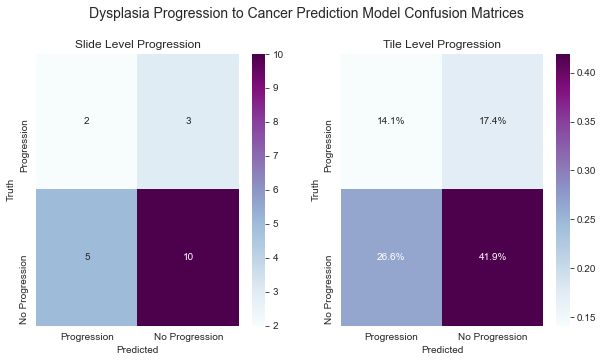

In [95]:
## Slide level, with percentage

tile_dysplasia = pd.read_parquet('/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/predictions/tile_predictions_eval.parquet.gzip')
patient_dysplasia = pd.read_parquet('/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/predictions/patient_predictions_eval.parquet.gzip')
slide_dysplasia = pd.read_parquet('/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/predictions/slide_predictions_eval.parquet.gzip')
datasets = [slide_dysplasia, tile_dysplasia]

renamed_datasets = []
for df in datasets:
    cols = df.columns.values
    for c in cols:
        if 'pred0' in c:
            pred_0 = c
        if 'pred1' in c:
            pred_1 = c
        if 'true' in c:
            truth = c
    df = df.rename(columns={pred_0:'pred_0', pred_1:'pred_1', truth:'truth'}).copy()
    renamed_datasets.append(df)

confusion_matrices = []
for df in renamed_datasets:
    df['binary_pred'] = df.apply(lambda row: 1 if row.pred_1 > 0.5 else 0, axis=1)
    confusion_matrix = metrics.confusion_matrix(df['truth'], df['binary_pred'])
    confusion_matrices.append(confusion_matrix)

print(confusion_matrices)
confusion_matrices = [np.array([[2,3],[5,10]]), np.array([[2240,2754], [4218,6645]])]

sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
fig.suptitle('Dysplasia Progression to Cancer Prediction Model Confusion Matrices', fontsize=14, y=1.01)

pt_level = sns.heatmap(confusion_matrices[0], annot=True, ax=axs[0], cmap='BuPu')
pt_level.set(xlabel='Predicted', ylabel='Truth', xticklabels=['Progression', 'No Progression'], yticklabels=['Progression', 'No Progression'], title='Slide Level Progression')

tile_level = sns.heatmap(confusion_matrices[1]/np.sum(confusion_matrices[1]), annot=True, ax=axs[1], cmap='BuPu', fmt='.1%')
tile_level.set(xlabel='Predicted', ylabel='Truth', xticklabels=['Progression', 'No Progression'], yticklabels=['Progression', 'No Progression'], title='Tile Level Progression')

fig.savefig('/Users/emmadyer/Desktop/pearson_lab/PROJECTS/scripps_dysplasia/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')